# X-TEC-s (GPU) (Peak averaging) analysis of Sr$_3$Rh$_4$Sn$_{13}$ XRD data

In this tutorial, we analyse the XRD data of Sr$_3$Rh$_4$Sn$_{13}$, a quasi-skutterudite family which shows charge density wave ordering  below a quantum critical point.

This tutorial takes single-crystal x-ray diffraction data in the data file `srn0_XTEC.nxs` available for download at https://dx.doi.org/10.18126/iidy-30e7

Here we implement label smoothing through peak averaging (fast and cheap for large data) for better identification of the order parameters (as compared to XTEC-d which shows fluctuations)  

## System requirements

The tutorial should run on any python version. We recommend: python 3.8 and Jupyter Notebook 6.3.0.





## Required python libraries

In [1]:
import glob
import os
import time

import matplotlib.pyplot as plt
import numpy as np

from nexusformat.nexus import (nxgetmemory, nxload, nxsetmemory, NXdata, 
                               NXentry, NXfield)





##  Required XTEC modules 

The following modules are required for the XTEC analysis:



In [ ]:
import sys
sys.path.append('../src/')


from Preprocessing import Mask_Zeros
from Preprocessing import Threshold_Background
from Preprocessing import Peak_averaging
from GMM import GMM as GMM



/data/UTe2XTEC/XTEC_GPU/XTECGPU/GMM_GPU.py:1: SyntaxWarning: invalid escape sequence '\p'
  """


# X-TEC flowchart

The flowchart below gives the steps we follow in this tutorial.

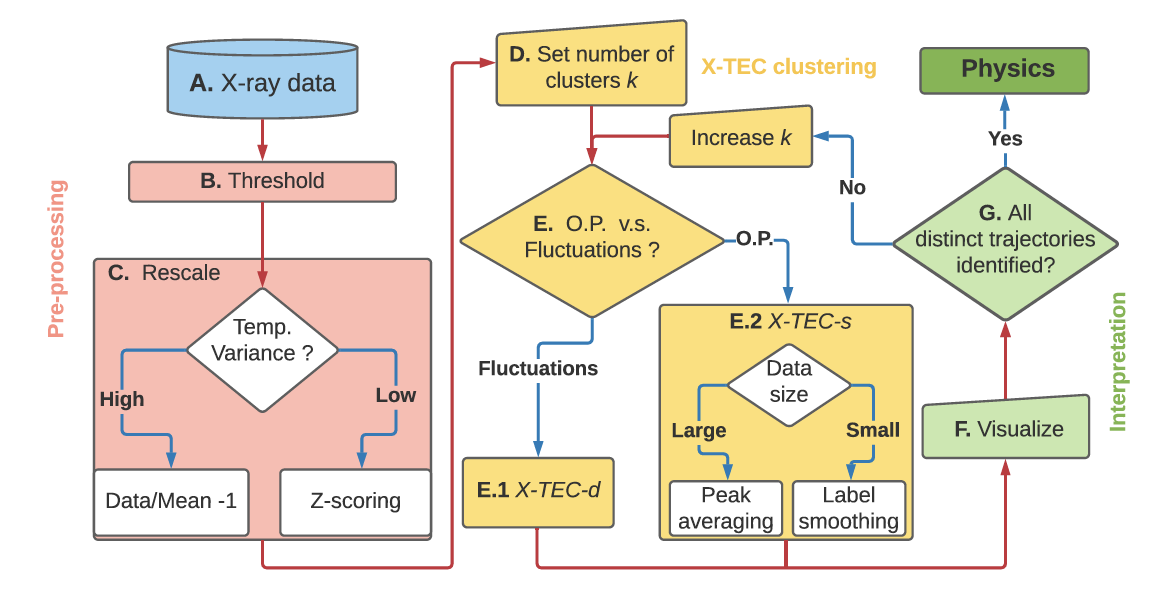

# Step A. Import the XRD Data

The data loading can be customized to the type of file and structure of data stored. 

Ultimately, one requires a temperature series of  intensity  at (Qh, Qk, Ql) points of the 3D reciprocal lattice (or equivalently in 2D reciprocal lattice) as an array with 

```
Data. shape = (num_Temperature, num_Ql, num_Qk, num_Qh) for 3D data (equivalently for 2D data).
```


#### From https://dx.doi.org/10.18126/iidy-30e7, download the data file      ```srn0_XTEC.nxs``` 

In [3]:
data_filename = 'srn0_XTEC.nxs'  # path to your datafile: srn0_XTEC.nxs

data_file = nxload(data_filename, 'r')
data = data_file['entry/data'][:, 0.0:1.0, -10.0:10.0, -15.0:15.0]

I = data.nxsignal.nxvalue    # intensities, shape= (num_Temperature, num_Ql, num_Qk, num_Qh)
Qh = data['Qh'].nxvalue      # Qh in r.l.u
Qk = data['Qk'].nxvalue      # Qk in r.l.u
Ql = data['Ql'].nxvalue      # Ql in r.l.u
Temp = data['Te'].nxvalue    # Temperatures



# Step B.1 Threshold background intensity 

The data is first put through a preprocessing to remove low intensity background noise. Assumes that the peaks/relevant x-ray features are sparse so that most momenta have predominantely background intensity contributions.

Cutoff automatically estimated by minimizing the Kullback-Leibler (KL) distance between the distribution of $\log[\overline{I_q(T)}]$ and a Gaussian distribution with (high intensity) sliding cutoff. See supplementary materials of  Venderley et al., https://arxiv.org/abs/2008.03275.  
 
See preprocessing.py for comments on the code 

In [4]:
start_time = time.time()

masked_torch    = Mask_Zeros(I, device='cuda:0')       # removes data with zero intensity. 
threshold_torch = Threshold_Background(masked_torch, device='cuda:0')    # remove low intensity background

print("Thresholding Run Time:",time.time() - start_time)

print('num of original data pixels=', np.prod(I.shape[1:])) 
print('num of thresholded data pixels=', threshold_torch.data_thresholded.shape[1])

Thresholding Run Time: 1.1033170223236084
num of original data pixels= 5061021
num of thresholded data pixels= 457679


The results from thresholding are stored as


```
    1.  threshold.data_thresholded : contains  thresholded data. 
                                     Shape=(num_T, num_thresholded_data)

    2.  threshold.ind_thresholded  : contains hkl indices of the thresholded data.
                                   Shape=(num_data_thresholded, 3) for 3D or (num_data_thresholded, 2) for 2D.

    3.  threshold.thresholded      :  stores whether the corresponding pixel is removed (=0) or not (=1).
                                      Shape=(num_l, num_k, num_h) or shape=(num_k, num_h) 
```

Let us see the thresholding results. Below is the distribution of intensities $(\log[\overline{I_q(T)}])$ and the truncation point (red dot) determined by thresholding. Only intensities above the truncation are retained.

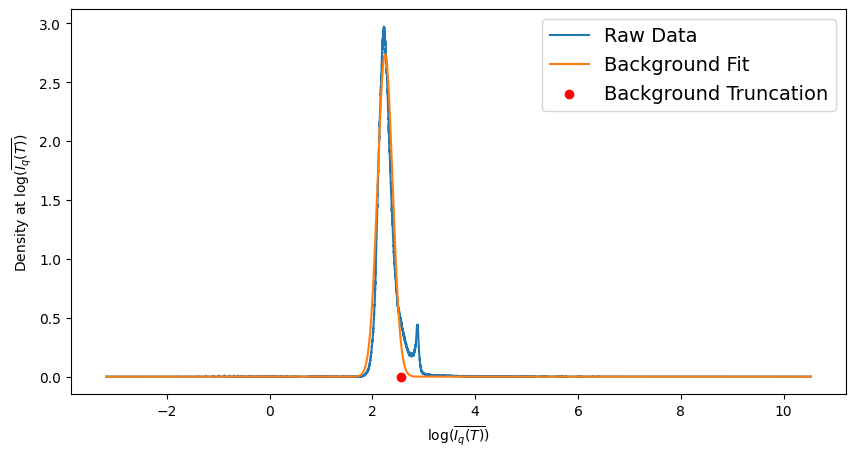

In [5]:
figsize_=(10,5)
threshold_torch.plot_cutoff(figsize_)

Note the non Gaussian features in the distribution just above the cutoff intensity (red dot). Those are the useful data we are after.

All data points that have $\log[\overline{I_q(T)}]$ above estimated cutoff are retained.

# Step B.2  Peak average the thresholded intensities 

 For each set of locally connected pixels in reciprocal space (peak clusters), their intensities are averaged within the peak to give a single peak averaged intensity representing the whole peak.  

In [6]:
start_time = time.time()
Peak_avg_torch       =  Peak_averaging(I,threshold_torch)      # this step implements peak averaging
Peak_avg_data_torch  =  Peak_avg_torch.peak_avg_data        # shape=(num_temperatures, num peak averaged data)

print("Peak averaging Run Time:",time.time() - start_time)



print('num of thresholded data pixels=', threshold_torch.data_thresholded.shape[1])
print('num of Peak averaged data =', Peak_avg_data_torch.shape[1])


Peak averaging Run Time: 0.2986891269683838
num of thresholded data pixels= 457679
num of Peak averaged data = 6089


# Step. C Rescale intensity


To reduce the large range in the scale of intensities and for efficient feature selection of the temperature trajectory, we provide two options to rescale intensities $I_q(T)$: 


#### Rescaling by mean:
subtracting and dividing their mean over temperature $\mu_{\vec{q}_i}=d_T^{-1}\sum_j I_{\vec{q}_i}(T_j)$  for each $q$,


\begin{equation}
	\tilde{I}_{\vec{q}_i}(T_j)=\dfrac{I_{\vec{q}_i}(T_j)}{\mu_{\vec{q}_i}}-1,
	\end{equation}
    
    
#### Z-scoring the data:
subtracting the mean (over T) and then dividing by standard deviation (over T) 
    
\begin{equation}
	\tilde{I}_{\vec{q}_i}(T_j)=\dfrac{I_{\vec{q}_i}(T_j)-\mu_{\vec q_i}}{\sigma_{\vec{q}_i}},
\end{equation}
    
where $\sigma_{\vec{q}_i}=\sqrt{d_T^{-1}\sum_j \left(I_{\vec{q}_i}(T_j)-\mu_{\vec q_i}\right)^2}$ is the standard deviation.
	

In [7]:
Rescaled_data_torch=threshold_torch.Rescale_mean(Peak_avg_data_torch)      # rescale by mean

#Rescaled_data=threshold.Rescale_zscore(Peak_avg_data)   # rescale by z-score|


print('num of thresholded and rescaled data = ', Rescaled_data_torch.shape[1] )
print('num T = ', Rescaled_data_torch.shape[0])

num of thresholded and rescaled data =  6089
num T =  24


# Step D: set number of clusters

Start with an initial guess (say 3 or 4), and run till step F (visualization). Revisit this step to change the num of clusters to arrive at the optimal choice. 

In [8]:
num_clusters = 3                             # change this to 3, 4, 5 etc and see. 

# Step E.2:  XTEC-s  with peak averaging 

We now apply GMM clustering.
The clustering is vanilla GMM (same as XTEC-d) but with peak averaged intensities.

In [9]:
Data_for_GMM_torch    = Rescaled_data_torch.T       # data should be arranged as (num_data,num_T) for GMM



start_time = time.time()
clusterGMM = GMM(Data_for_GMM_torch,num_clusters) # set the data and number of clusters for GMM
clusterGMM.RunEM()                          # performs the simple EM algorithm to cluster trajectories
print("GMM Run Time:",time.time() - start_time)


cluster_assignments=clusterGMM.cluster_assignments 
print('num of trajectories in each cluster = ', clusterGMM.num_per_cluster)



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=2` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to 

Epoch 37: 100%|██████████████████████████████| 1/1 [00:00<00:00, 124.14it/s, nll=-13.0]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████████████████████| 1/1 [00:00<00:00, 253.36it/s]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████████████████████| 1/1 [00:00<00:00, 265.83it/s]
GMM Run Time: 1.1089940071105957
num of trajectories in each cluster =  [3509, 1058, 1522]


Clustering results are stored in clusterGMM as

```
clusterGMM.cluster_assignments : cluster assignment k in range(num_clusters), of each sample. 
                                 Shape=(num_peak averaged_data)
clusterGMM.num_per_cluster : number of trajectories in each cluster.

clusterGMM.cluster[k].mean: cluster mean trajectory (dim=num_Temperature) of the k-th cluster
clusterGMM.cluster[k].cov : cluster covariance [dim=num_Temperature] of the k-th cluster
       

```

# Step F. Visualization of clustered results.

Let us plot the cluster mean of the rescaled data (lines), with 1 standard deviation shaded, for the clusters color coded as red blue green violet etc. 

<>:4: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_904511/3437136811.py:4: SyntaxWarning: invalid escape sequence '\w'
  plt.ylabel('$\widetilde{I}_q(T)$', size=18)


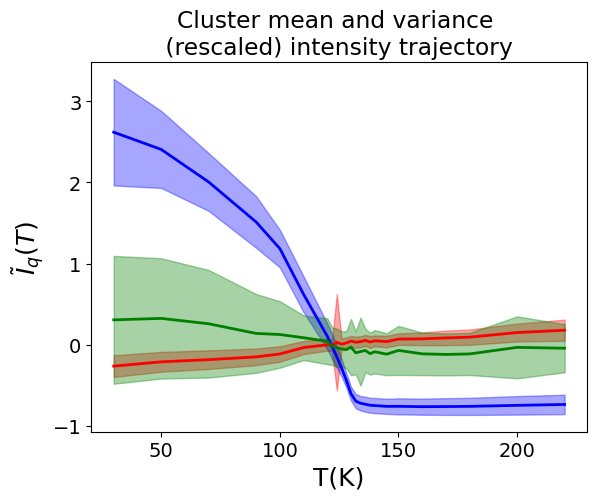

In [10]:
clusterGMM.Plot_Cluster_Results_traj(Temp)  # Plotting for only less than 7 clusters currently enabled.  

plt.xlabel('T(K)', size=18)
plt.ylabel('$\widetilde{I}_q(T)$', size=18)
plt.title('Cluster mean and variance \n (rescaled) intensity trajectory ');

The order parameter like behavior of one of the cluster is apparent, with a transition temperature $T_c\approx 130 K$ This cluster corresponds to the CDW peak. To see that, let us plot and see which pixels in the $(h,k)$ plane belong to the red/blue/green/violet cluster.   

### Assign the cluster label of the peak to all pixels contained within the peak

### Plot the clustering results in reciprocal space

In [11]:
clusterGMM.Get_pixel_labels(Peak_avg_torch)

Data_ind           =  clusterGMM.Data_ind            # (hkl) indices of all the pixels. shape=(num_thresholded_data,3) 
Pixel_assignments  =  clusterGMM.Pixel_assignments   # cluster assignments of all pixels, shape=(num_thresholded_data)



Text(0.5, 1.0, 'L=0.0')

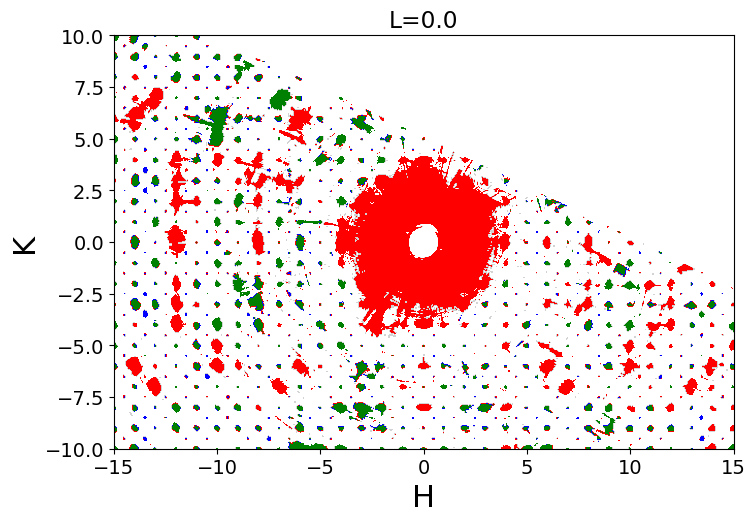

In [12]:
figsize_ = (8,8)

axis_ind = 0   # Select 0 for plotting l plane, 1 for k plane, 2 for h plane 
slice_value = 0.0 # Value of the axis orthogonal to the selected plane
slice_ind = data.nxaxes[axis_ind+1].index(slice_value) # index of  the selected axis (h/k/l plane) to plot

Data_for_GMM_ind =  Data_ind  #(hkl) indices of the data that was clustered 


clusterGMM.Plot_Cluster_kspace_2D_slice(threshold_torch,figsize_,Data_ind,slice_ind,axis_ind,Pixel_assignments) 



ax = plt.gca()
ax.get_images()[0].set_extent((Qh[0], Qh[-1], Qk[0], Qk[-1])) 
plt.xlabel("H", size=22)
plt.ylabel("K", size=22)
plt.title(f'L={slice_value}')

Text(0.5, 1.0, 'L=0.0')

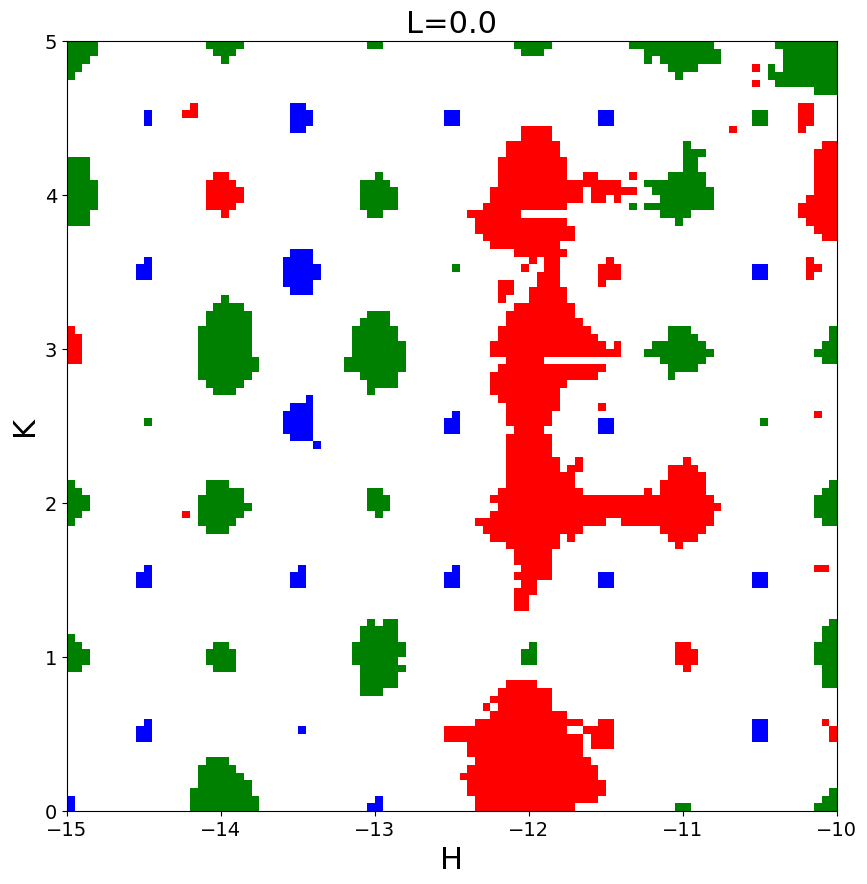

In [13]:
# a zoom in image of the above figure..
plt.figure(figsize=(10,10))

plt.imshow(clusterGMM.plot_image[200:300,0:100], origin='lower', cmap=clusterGMM.plot_cmap, norm=clusterGMM.plot_norm, extent=[Qh[0], Qh[100], Qk[200], Qk[300]])

plt.xlabel("H", size=22)
plt.ylabel("K", size=22)
plt.title(f'L={slice_value}', size=22)


Notice that CDW peaks at $q_{CDW} = (H+0.5,K+0.5,0)$ have the same color matching the color of the order parameter like trajectory.





### At this point, we already see the CDW peaks and their intensity trajectory reflecting the order parameter.  


# Final step: Physics!

Store the clustered results and identify the physics in them

### Plot the cluster averaged intensities to see the order parameter

Text(0, 0.5, 'I (cluster avged)')

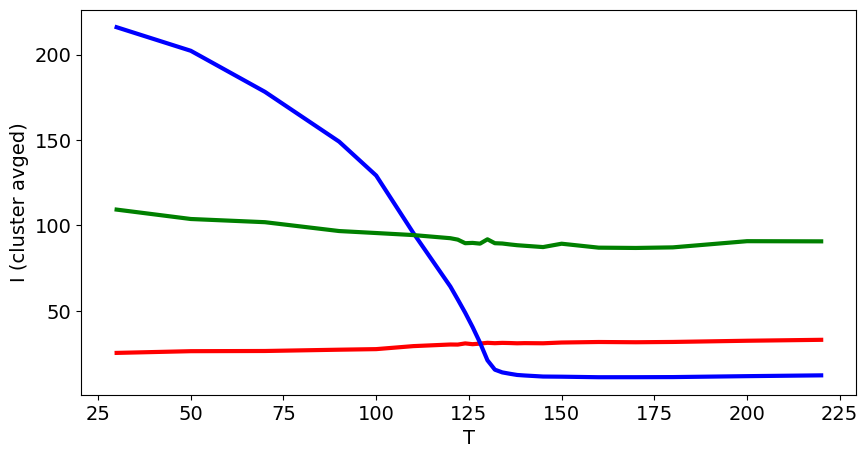

In [14]:
plt.figure(figsize=(10,5))
color_list = ['red', 'blue', 'green', 'purple', 'yellow', 'orange', 'pink', 'black', 'grey', 'cyan']

yc_plot={}
for i in range(clusterGMM.cluster_num):
    cluster_mask_i = (clusterGMM.cluster_assignments == i)
    yc_plot[i]=np.mean(Peak_avg_data_torch[:,cluster_mask_i].detach().cpu().numpy(),axis=1).flatten()
    plt.plot(Temp,yc_plot[i],color=color_list[i], lw=3);

plt.yscale("linear")
plt.xlabel('T')
plt.ylabel('I (cluster avged)')


## Harnessing Interpretable and Unsupervised Machine Learning to Address Big Data from Modern X-ray Diffraction

### https://arxiv.org/abs/2008.03275 

###### Jordan Venderley,  Krishnanand Mallaya, Michael Matty, Matthew Krogstad, Jacob Ruff, Geoff Pleiss, Varsha Kishore, David Mandrus, Daniel Phelan, Lekh Poudel, Andrew Gordon Wilson, Kilian Weinberger, Puspa Upreti, M. R. Norman, Stephan Rosenkranz, Raymond Osborn, Eun-Ah Kim


### Tutorial by Krishnanand Mallayya. Adapted for the Torch GPU version by Yanjun Liu and Aaditya Panigrahi. 
### For questions about X-TEC code and tutorial contact kmm537@cornell.edu (Krishnanand), yl3447@cornell.edu (Yanjun) and ap2563@cornell.edu (Aaditya).

